# Prepare Raw Data

Check that all projects have data in each of the three input folders:
```
southernoperations/
└── AIID/
    ├── AVG/
    ├── CMP/
    └── YAW/
```

Run the cell below to check that the right files are in place 

In [ ]:
import sys
import os

sys.path.append('..')
from Model.Constants.General import TURBINE_TECH

# Get the List of projects from constants
projects = list(TURBINE_TECH.keys())

# Directory containing raw data
raw_data_dir = '../southernoperations/AIID'

# Subfolders to check within the raw data directory
subfolders = ['AVG', 'CMP', 'YAW']

# Iterate through each subfolder
for subfolder in subfolders:
    print(f"Checking in subfolder: {subfolder}")
    subfolder_path = os.path.join(raw_data_dir, subfolder)

    if not os.path.exists(subfolder_path):
        print(f"Subfolder {subfolder} does not exist.")
        continue

    # Check for each project in the subfolder
    for project in projects:
        project_files = [f for f in os.listdir(subfolder_path) if project in f]
        
        if not project_files:
            print(f"No files found for project {project} in {subfolder}")
        else:
            print(f"Files found for project {project} in {subfolder}: {project_files}")



# Initialize WindFarm
In an actual data update you would execute the transformations for all projects using a `Fleet` object which is composed of `WindFarm` objects. However, for Illustration of how the data is processed step by step it is easier to work with a `WindFarm` object directly. The functionality of the Fleet object will be shown further down. 

We will use PDK as the training project because it is small and runs quickly. 

In [ ]:
import sys
sys.path.append('..')
from Model.WindFarm import WindFarm
project ='PDK'
wf = WindFarm(avg_path=f'../southernoperations/AIID/AVG/{project}_sc_avg.csv',
              compressed_path=f'../southernoperations/AIID/CMP/{project}_sc_cmp.csv',
              yaw_path = f'../southernoperations/AIID/YAW/{project}_sc_yaw.csv',
              project=project,
              )

# WindFarm Class Setup 
Its useful to understand whats happening when each `WindFarm` object is instantiated. Here are the important things:



## 1.Create CSV Data Repository
   A `CSV_Repository` is created with the 10 minute average project file. The repository will store the data needed for the transformation process and expose methods to retreive the data. 

```python
    self.repository = RepositoryFactory.create_repository(
            data_source_type=data_source_type, data=input_data
        )
```

The yaw data is then added to the repository. 
```python
self.repository.add_data(yaw_input_data, freq="10s")
```

In [ ]:
# Get All column Names in the windfarm repository

wf.repository.get_all_column_names()

In [ ]:
# Retrieve spefic columns from the repository
display(wf.repository.get_column_data( ['PDK-T001-KW']).head())

display(wf.repository.get_column_data(['PDK-T001-YAW-DIR','PDK-T002-YAW-DIR']).head())

## 2.Discover Types and Create Farm Components
for each tag type a farmcomponent is created. FarmComponent encapsulates data of a certain type that is cleaned and processed together. 

The code below is from `Utils.Transformers.get_component_types()` and it is where the application is discovering the tag types that will be grouped to create the collection of `FarmComponent`s.

```python
for col_name in columns:
        tag_type_suffix = component_type_func(col_name)

        if tag_type_suffix not in tag_type_suffixes:
            tag_type_suffixes.append(tag_type_suffix)

        component_type = component_type_map(tag_type_suffix)
        if component_type is None:
            continue

        if component_type not in component_type_list:
            component_type_list.append(component_type)

    return component_type_list, tag_type_suffixes

```

Notice that component_type_func, which is just a lambda that capitalizes on the fact that the type portion of each tag is the 3rd segment on when split by '-'. 

the tag suffix is then converted by `component_type_map` whichwraps the `KEY_TO_NAME` dictionary stored in `Utils.Constants`

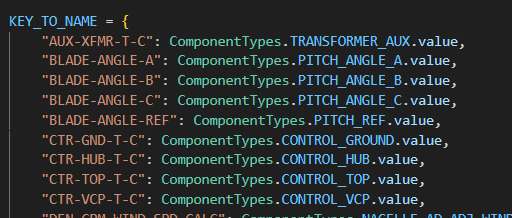

This is the mechanism that converts the data types to a properties on `WindFarm`. The tag type suffixes map to Enum Values and the Enum values become property names. 

Normalized `FarmComponent` Names stored as an Enumeration:
```python
class ComponentTypes(Enum):
    ACTIVE_POWER = "active_power"
    CONTROL_GROUND = "Ctrl_Gnd_Temp"
    CONTROL_HUB = "Ctrl_Hub_Temp"
    CONTROL_TOP = "Ctrl_Top_Temp"
    CONTROL_VCP = "Ctrl_VCP_Temp"
    EFFICIENCY = "Efficiency"
    EXPECTED_POWER = "expected_power"
    FAULT_CODE = "fault_code"
    GEARBOX_COOLING_WATER_TEMP = "Gbx_CoolingWater_Temp"
    GEARBOX_MAIN_TANK = "Gbx_Internal_Temp"
    GEARBOX_OIL = "Gbx_Oil_Temp"
    GENERATOR_1_TEMPERATURE = "Gen_Internal_Temp"
    ...
```

### Show all `FarmComponents` added to `WindFarm`

In [ ]:

from Model.WindFarm import FarmComponent
for component in wf.components:
    if isinstance(wf.components[component],FarmComponent):
        print(component)

### Access a specific `FarmComponent` property on `WindFarm`
Each of the types above become a property of type `FarmComponent` on the containing `WindFarm`. They can be accessed via the `components` propert as in the above cell or directly through the created property. 


In [ ]:
print('As a property')
print(wf.HPU_Oil_Temp)

print("accessed through the compnents property")
print(wf.components['HPU_Oil_Temp'])

### 2a. `FarmComponent` 
 Farm component is responsible for calculating daily severities and daily mean temeperatures on Temperature Tags

Farm component is behind the result produced when you call `fleet.daily_severity_scores`

`fleet.daily_severity_scores`--> `fleet.get_flagged_turbines`-->`windfarm.get_flagged_turbines`-->`FarmComponent.get_flagged_turbines`--> `FarmComponent.get_severity_scores` 
this sequence results in `FarmComponent.get_flagged_turbines` returning the tope N flagged turbines AND the daily severity scores

#### Severity Scores

In [ ]:
wf.HPU_Oil_Temp.get_severity_scores().tail()

#### Gradient Filter Params

In [ ]:
wf.HPU_Oil_Temp.gradient_filter_parameters

#### Gradient Filtered Data


In [ ]:
wf.Ctrl_Hub_Temp.gradient_filtered_data.tail()

#### Gradient Filtered Statistics

In [ ]:
wf.Hub_Temp.gradient_filtered_stats

#### Range Filter Parameters

In [ ]:
wf.Gbx_Brg_HighSpd_Temp.range_filter_parameters

#### Range Filtered Data

In [ ]:
wf.Ctrl_Hub_Temp.range_filtered_data.tail()

#### Range Filtered Statistics

In [ ]:
wf.HPU_Oil_Temp.range_filtered_stats

#### Online Filtered Data

In [ ]:
wf.active_power.online_filtered_data.tail()

#### Fully Clean Data

In [ ]:
wf.Nacl_AD_ADj_Wind_Speed.clean_data.tail()

#### Daily Mean

In [ ]:
wf.HPU_Oil_Temp.daily_mean.tail()

### 2b. `CalculatedFarmComponent`
This class calculates simple efficiency. 

#### Ten Minute Efficiency

In [ ]:
wf.Lost_Energy.efficiency.tail()

#### Daily Efficiency

In [ ]:
wf.Lost_Energy.daily_efficiency.tail()

#### Lost energy

In [ ]:
wf.Lost_Energy.lost_energy.tail()

#### Daily lost energy

In [ ]:
wf.Lost_Energy.daily_lost_energy.tail()

#### Daily lost revenue

In [ ]:
wf.Lost_Energy.daily_lost_revenue.tail()

### 2c. `CalculatedYawErrorFarmComponent`

#### Daily Yaw Error


In [ ]:
wf.Yaw_Error.get_severity_scores().tail()

# Fleet 
The fleet class is for the most part an aggregator of windfarms
and provides a convenitent way to iterate through each wind farm to calculate metrics over all turbines in the fleet. 

In [ ]:
import sys
sys.path.append('..')
from Model.Fleet import Fleet

cmp_dir = '../southernoperations/AIID/CMP/'
avg_dir = '../southernoperations/AIID/AVG/'
yaw_dir = '../southernoperations/AIID/YAW/'
oem_power_curve_path = '../assets/data/power_curves/all_power_curves.csv'

fleet = Fleet(avg_dir=avg_dir, 
              cmp_dir=cmp_dir,
              yaw_dir=yaw_dir,
              oem_powercurves_path=oem_power_curve_path,
              single_plant='PDK')




# Power Curves
Power curves are accessed through the Fleet and Wind Farm Objects but the Power Curve Calculation logic is encapsulated  by the Model.PowerCurve class

## Accessing Power Curves Through Fleet
This will return a file of daily power curves for all turbines for the fleet

In [ ]:
# Here is how the fleet power curve dataset is accessed on Fleet
display(fleet.get_powercurves())

## power Curves through WindFarm
Fleet is simply calling the `powercurves` property on `WindFarm` and concatenating across all plants

this is the entirety of the fleet `get_powercurves()` method:
```python
powercurves = []
        for wf_name, windfarm in self.windfarms.items():
            print(f"Fleet 391: Calculating Power Curves for {wf_name}")
            powercurves.append(windfarm.powercurves)

        fleet_powercurves = pd.concat(powercurves)

        return fleet_powercurves

```

calling the `powercurves` property from `WindFarm` yields the same structure file but for the single plant. 

In [ ]:
windfarm =fleet.windfarms['PDK']

display(windfarm.powercurves)

# The PowerCurve Class: Power Curve Calculation
`Fleet` asks for powercurves from each `WindFarm` and `WindFarm` in turn asks `PowerCurve` for power curves from the `PowerCurve.daily_power_curve` property when `WindFarm.powercurves` is requested the first time.  

When the `WindFarm.powercurves` is accessed for the first time 
a dataframe containing clean Active Power and Air Density Adjusted Wind Speed is passed to `PowerCurve` to create the object along with the project name and the single OEM Power Curve for the given plant. 

In [ ]:
import pandas as pd
import sys
sys.path.append('..')
from Utils.Enums import ComponentTypes
from Model.PowerCurve import PowerCurve 
# Creation of a `PowerCurve` class
input_data = pd.concat(
                [
                    windfarm.components[
                        ComponentTypes.NACELLE_AD_ADJ_WIND_SPEED.value
                    ].clean_data,
                    windfarm.components[ComponentTypes.ACTIVE_POWER.value].clean_data,
                ],
                axis=1,
            )

power_curve = PowerCurve(
    data=input_data,
    project_name=windfarm.name,
    oem_power_curve=windfarm.oem_powercurve,
)

display(power_curve.get_daily_power_curves())

# Fault

## Initialize the Fault Class

In [54]:
import sys 
sys.path.append('..')
from Model.Fault import FaultAnalysis
project = 'PDK'

fault_data_path = f"../southernoperations/AIID/CMP/{project}.csv"
avg_data_path = f"../southernoperations/AIID/AVG/{project}_concat.csv"

cmp_data = pd.read_csv(fault_data_path, low_memory=False)
avg_data = pd.read_csv(avg_data_path, index_col=[0], parse_dates=[0])

faults = FaultAnalysis(project=project, cmp_data=cmp_data, avg_data=avg_data)

downtime_data = faults.reshaped_data
  

        PDK-T001
        PDK-T002
        PDK-T003
        PDK-T004
        PDK-T005
        PDK-T006
        PDK-T007
        PDK-T008
        PDK-T009
        PDK-T010
        PDK-T011
        PDK-T012
        PDK-T013


## downtime lost energy data

In [55]:
faults.reshaped_data.tail()

,FaultCode,Turbine,StartDateTime,EndDateTime,PreAdjustedDuration,OriginalStartDateTime,OriginalEndDateTime,NextStartDateTime,AdjustedDuration,AdjustedStartDateTime,AdjustedEndDateTime,LostEnergy,LostRevenue
184,309.0,PDK-T013,2023-11-02 17:30:00,2023-11-02 17:40:00,1330.0,2023-11-02 17:28:34,2023-11-02 17:50:44,2023-11-14 06:16:15,600.0,2023-11-02 17:30:00,2023-11-02 17:40:00,0.155319,13.195007
185,3273.0,PDK-T013,2023-11-14 06:16:15,2023-11-14 06:30:00,950.0,2023-11-14 06:16:15,2023-11-14 06:32:05,2023-11-24 17:10:00,825.0,2023-11-14 06:16:15,2023-11-14 06:30:00,0.003017,0.256289
186,309.0,PDK-T013,2023-11-24 17:10:00,2023-11-24 17:20:00,899.0,2023-11-24 17:09:45,2023-11-24 17:24:44,2023-11-27 14:50:00,600.0,2023-11-24 17:10:00,2023-11-24 17:20:00,0.537160,45.633871
187,4517.0,PDK-T013,2023-11-27 14:50:00,2023-11-27 14:58:15,590.0,2023-11-27 14:48:25,2023-11-27 14:58:15,2023-11-27 14:59:15,495.0,2023-11-27 14:50:00,2023-11-27 14:58:15,0.286048,24.300885
188,6293.0,PDK-T013,2023-11-27 14:59:15,2023-11-27 15:00:00,120.0,2023-11-27 14:59:15,2023-11-27 15:01:15,NaT,45.0,2023-11-27 14:59:15,2023-11-27 15:00:00,0.026392,2.242140


## Daily Downtime

In [57]:
faults.daily_downtime().tail()

,Date,Turbine,FaultCode,Downtime
152,2023-11-27,PDK-T005,6293.0,110.0
153,2023-11-27,PDK-T006,144.0,6000.0
154,2023-11-27,PDK-T007,144.0,1200.0
155,2023-11-27,PDK-T013,4517.0,495.0
156,2023-11-27,PDK-T013,6293.0,45.0


## Daily Lost Energy

In [59]:
faults.daily_lost_energy().tail()

,Date,Turbine,FaultCode,LostEnergy
152,2023-11-27,PDK-T005,6293.0,0.057525
153,2023-11-27,PDK-T006,144.0,1.279599
154,2023-11-27,PDK-T007,144.0,0.000000
155,2023-11-27,PDK-T013,4517.0,0.286048
156,2023-11-27,PDK-T013,6293.0,0.026392


## Daily Lost Revenue

In [60]:
faults.daily_lost_revenue().tail()

,Date,Turbine,FaultCode,LostRevenue
152,2023-11-27,PDK-T005,6293.0,4.886966
153,2023-11-27,PDK-T006,144.0,108.707089
154,2023-11-27,PDK-T007,144.0,0.000000
155,2023-11-27,PDK-T013,4517.0,24.300885
156,2023-11-27,PDK-T013,6293.0,2.242140


## Daily Fault Count

In [ ]:
faults.daily_fault_count().tail()